<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/Noise-CBCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Franck P. Vidal (Bangor University, UK)

# ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1) a data reader for CIL
 
This demo shows the result of the integration between gVirtualXray (gVXR) and the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/) that we developed during the *CIL Training and Bring Your Own Data User Hackathon* at Cambridge University. A cone-beam computed-tomography (CBCT) acquisition with Poisson noise is simulated with [gVXR](https://sourceforge.net/projects/gvirtualxray). The data is reconstructed with [CIL](https://github.com/TomographicImaging/CIL).

Author: Franck Vidal

Version: 1.1, 3 Mar 2023

# Aims of this session

1. Simulate a CBCT scan acquisition using gVXR;
2. Add Poisson noise corresponding to a given number of photons per pixel; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/).


In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filtration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator. 15,000 photons per pixels are used. 600 projections of 512x512 pixels are taken.

![Main parameters of the simulation](https://github.com/effepivi/CIL-User-Showcase/blob/gVXR2CIL/gVXR2CIL/pediatric-setup.png?raw=1)



# Main steps

1. Download the phantom data. Anthropomorphic data is used. It corresponds to a 5-year old boy. 

2. Extract surface meshes from the voxelied phantom.

3. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/visualisation.png)

4. Select the number of incident photons per pixel

5. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/noisy-projection.png)

6. Simulate a CT scan

![Scanning eometry](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/CT-geometry.png)

7. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/average-flat-field.png)

8. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://raw.githubusercontent.com/effepivi/CIL-User-Showcase/gVXR2CIL/gVXR2CIL/plotCT.png)

# Run the following only if on google colab

In [2]:
#from jupyter_server import serverapp as notebookapp
#servers = list(notebookapp.list_running_servers())

#if len(servers) > 0:
#    !pip install -q condacolab
#    import condacolab
#    condacolab.install()

### Install gVXR, k3D, imagecodecs xpecgen, spekpy and SimpleITK

Run the cell below

```python
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk
```

In [3]:
#from notebook import notebookapp
#servers = list(notebookapp.list_running_servers())

#if len(servers) > 0:
#    !pip3 install -q gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk vtk

In [4]:
#from notebook import notebookapp
#servers = list(notebookapp.list_running_servers())

#if len(servers) > 0:
#    !mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox --quiet

# If running locally 

### CIL version: 23.0.1

In [5]:
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk scikit-image vtk

  Cloning https://bitbucket.org/spekpy/spekpy_release.git to /tmp/pip-req-build-331unn93
  Running command git clone --filter=blob:none --quiet https://bitbucket.org/spekpy/spekpy_release.git /tmp/pip-req-build-331unn93
  Resolved https://bitbucket.org/spekpy/spekpy_release.git to commit 547d80c4575e718e5c5a51472eb583188dbdd3ad
  Preparing metadata (setup.py) ... done


# Import libraries 

In [6]:
import glob
import zipfile

import pandas as pd

from IPython.display import display
from IPython.display import Image

import matplotlib.pyplot as plt # Plotting
%matplotlib inline

import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

import matplotlib # To plot images

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

has_rtk = True
try:
    import itk
    from itk import RTK as rtk
    print("RTK detected")
except:
    has_rtk = False
    print("RTK not detected")



# Make sure the Astra-toolbox is installed
has_astra = True
try:
    # FBP and FDK with Astra
    from cil.plugins.astra import FBP as FBP_plugin_astra
    print("Astra-toolbox detected")
except:
    has_astra = False
    print("Astra-toolbox not detected")
    
# Make sure the Tigre is installed
has_tigre = True
try:
    # FBP and FDK with Tigre
    from cil.plugins.tigre import FBP as FBP_plugin_tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

# Make sure CIL is installed
has_cil = True
try:
    from cil.processors import TransmissionAbsorptionConverter
    from cil.utilities.display import show_geometry, show2D

    # FBP with Tigre or Astra
    from cil.recon import FBP as FBP_recons_cil

    # FDK with Tigre only
    from cil.recon import FDK as FDK_recons_cil # Tigre only
    
    # Do not use
    # from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    

    print("CIL detected")
except:
    has_cil = False
    print("CIL not detected")

# Make sure the sliders for Jupyter can be used
has_cil_islider = True
try:
    from cil.utilities.jupyter import islicer
except:
    has_cil_islider = False


from ipywidgets import interact
import ipywidgets as widgets

import base64

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales

from sitk2vtk import *

if has_cil:
    from JSON2gVXRDataReader import *

import pathlib
root_path = str(pathlib.Path().resolve())

RTK detected
Astra-toolbox detected
Tigre detected
CIL detected
SimpleGVXR 2.0.6 (2023-05-23T15:10:16) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T15:10:15) [Compiler: GNU g++] on Linux


# Get data

In [7]:
# For Google Collab
import os
import urllib.request

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/CIL-User-Showcase/blob/gVXR2CIL/gVXR2CIL/"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory(root_path + "/meshes")

downloadFile("sitk2vtk.py")
downloadFile("JSON2gVXRDataReader.py")
downloadFile("Noise-CBCT.json")
downloadFile("energyResponseDetector.txt")
downloadFile("spectrum85kV.txt")
downloadFile("labels.dat")
downloadFile("visualisation.png")
downloadFile("CT-geometry.png")

## Initialise GVXR using our JSON file

In [8]:
json_fname = root_path + "/Noise-CBCT.json"
json2gvxr.initGVXR(json_fname, renderer="EGL")

Create an OpenGL context: 800x450


Tue Aug 15 13:30:13 2023 ---- Create window (ID: -1)
Tue Aug 15 13:30:13 2023 ---- Query the number of EGL devices
Tue Aug 15 13:30:13 2023 ---- Success
Tue Aug 15 13:30:13 2023 ---- Detected 5 EGL devices.
Tue Aug 15 13:30:13 2023 ---- Print the details here of every EGL device.
Tue Aug 15 13:30:13 2023 ---- Success
Tue Aug 15 13:30:13 2023 ---- Device 1/5:
Tue Aug 15 13:30:13 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Tue Aug 15 13:30:13 2023 ---- Device 2/5:
Tue Aug 15 13:30:13 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Tue Aug 15 13:30:13 2023 ---- Device 3/5:
Tue Aug 15 13:30:13 2023 ---- 	Device Extensions: EGL_EXT_device_drm EGL_EXT_device_drm_render_node
Tue Aug 15 13:30:13 2023 ---- Device 4/5:
Tue Aug 15 13:30:13 2023 ---- 	Device Extensions: EGL_EXT_device_

## Create the output directory

In [9]:
raw_projection_output_dir = os.path.abspath(json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"]))
print("The raw projections were saved in", raw_projection_output_dir)
createDirectory(raw_projection_output_dir + "/..")
createDirectory(raw_projection_output_dir)

The raw projections were saved in /home/bih17925/CIL_user_notebooks/gVXR2CIL/raw_projections


## Load our detector

In [10]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [512, 512]
	Detector number of pixels: [512, 512]
	Energy response: energyResponseDetector.txt in MeV
	Pixel spacing: [0.9765625, 0.9765625, 'mm']


In [11]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [12]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 1000.0, 0.0, 'mm']
	Source shape: PointSource


In [13]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Tue Aug 15 13:30:13 2023 ---- Initialise the renderer


Text(0.5, 1.0, 'Corresponding spectra')

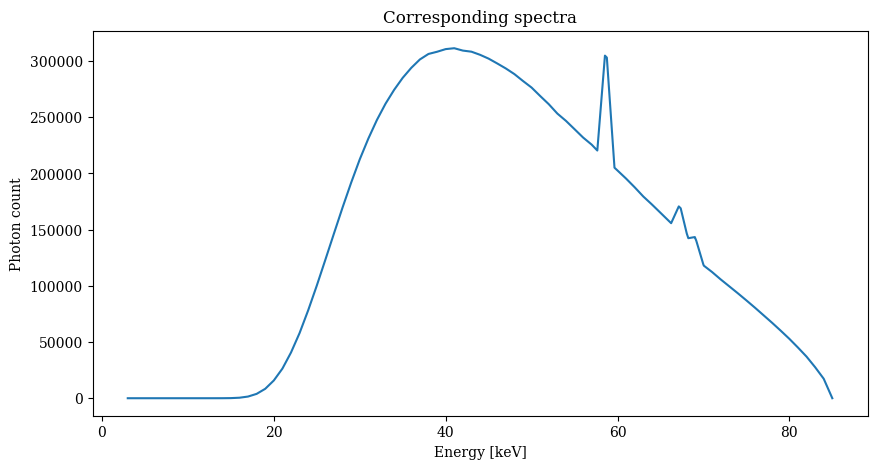

In [14]:
plt.figure(figsize=(10,5))
plt.plot(energy_set, bin_sets)
plt.xlabel("Energy [" + unit_of_energy + "]")
plt.ylabel("Photon count")
plt.title("Corresponding spectra")

## Create the surface meshes

Download and extract the ZIP file.

In [15]:
if not os.path.exists("Pediatric phantom.zip") or not os.path.exists("Pediatric phantom"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1",
                               root_path + "/Pediatric phantom.zip")

    with zipfile.ZipFile(root_path + "/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall(root_path)

Load the phantom

In [16]:
phantom = sitk.ReadImage(root_path + "/Pediatric phantom/Pediatric_model.mhd")

Load the labels

In [17]:
df = pd.read_csv(root_path + "/labels.dat")

Process every structure of the phantom

In [18]:
meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        mesh_fname = root_path + "/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):
            
            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Smooth the binary segmentation
            smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                            
            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            writeSTL(vtk_mesh, mesh_fname)

Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


In [19]:
del phantom

## Load our samples

In [20]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

	Load Muscle in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Muscle.stl using mm
	Load Bone in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Bone.stl using mm
	Load Stomach-Interior in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Stomach-Interior.stl using mm
	Load Cartilage in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Cartilage.stl using mm
	Load Brain in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Brain.stl using mm
	Load Bladder in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Bladder.stl using mm
	Load Gallbladder in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Gallbladder.stl using mm
	Load Heart in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Heart.stl using mm
	Load Kidneys-right in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Kidneys-right.stl using mm
	Load Kidneys-left in /home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Kidneys-left.stl using mm
	Load Small-Intestine in /home/bih17925/CIL_user_notebooks/gVXR2CI

Tue Aug 15 13:30:14 2023 ---- file_name:	/home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Muscle.stl	nb_faces:	1756726	nb_vertices:	5270178	bounding_box (in cm):	(-17.9687, -10.8887, -30.9017)	(16.6016, 11.1799, 28.6986)
Tue Aug 15 13:30:14 2023 ---- file_name:	/home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Bone.stl	nb_faces:	541826	nb_vertices:	1625478	bounding_box (in cm):	(-16.7969, -23.6577, -30.9017)	(15.2152, 9.88865, 16.3501)
Tue Aug 15 13:30:14 2023 ---- file_name:	/home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Stomach-Interior.stl	nb_faces:	9452	nb_vertices:	28356	bounding_box (in cm):	(-1.34334, -2.38867, -17.0041)	(4.16143, 3.05231, -8.50205)
Tue Aug 15 13:30:14 2023 ---- file_name:	/home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Cartilage.stl	nb_faces:	163322	nb_vertices:	489966	bounding_box (in cm):	(-16.7615, -4.32288, -30.9017)	(15.5041, 8.717, 16.6771)
Tue Aug 15 13:30:14 2023 ---- file_name:	/home/bih17925/CIL_user_notebooks/gVXR2CIL/meshes/Brain.stl	nb_faces:

In [21]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-172.85147094726562, -174.18807983398438, -300.0243225097656] [172.85147094726562, 174.18809509277344, 300.0243225097656]
Bounding box centre: [0.0, 7.62939453125e-06, 0.0]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`. 
By default the image is expressed in MeV. 
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

In [22]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

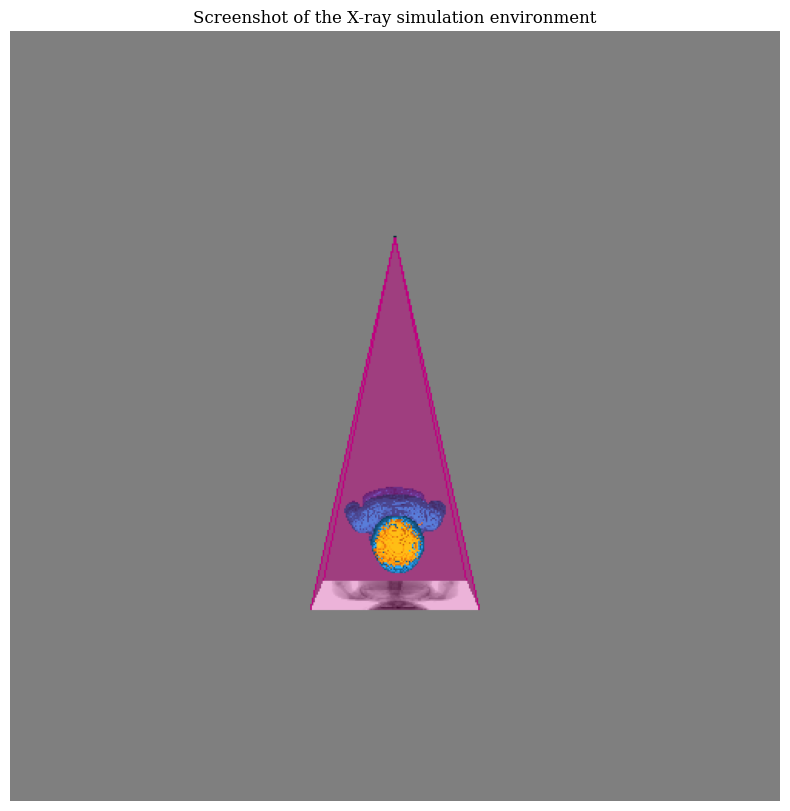

In [23]:
gvxr.setWindowSize(500, 500) # Fix for MacOS
gvxr.displayScene()
plotScreenshot()

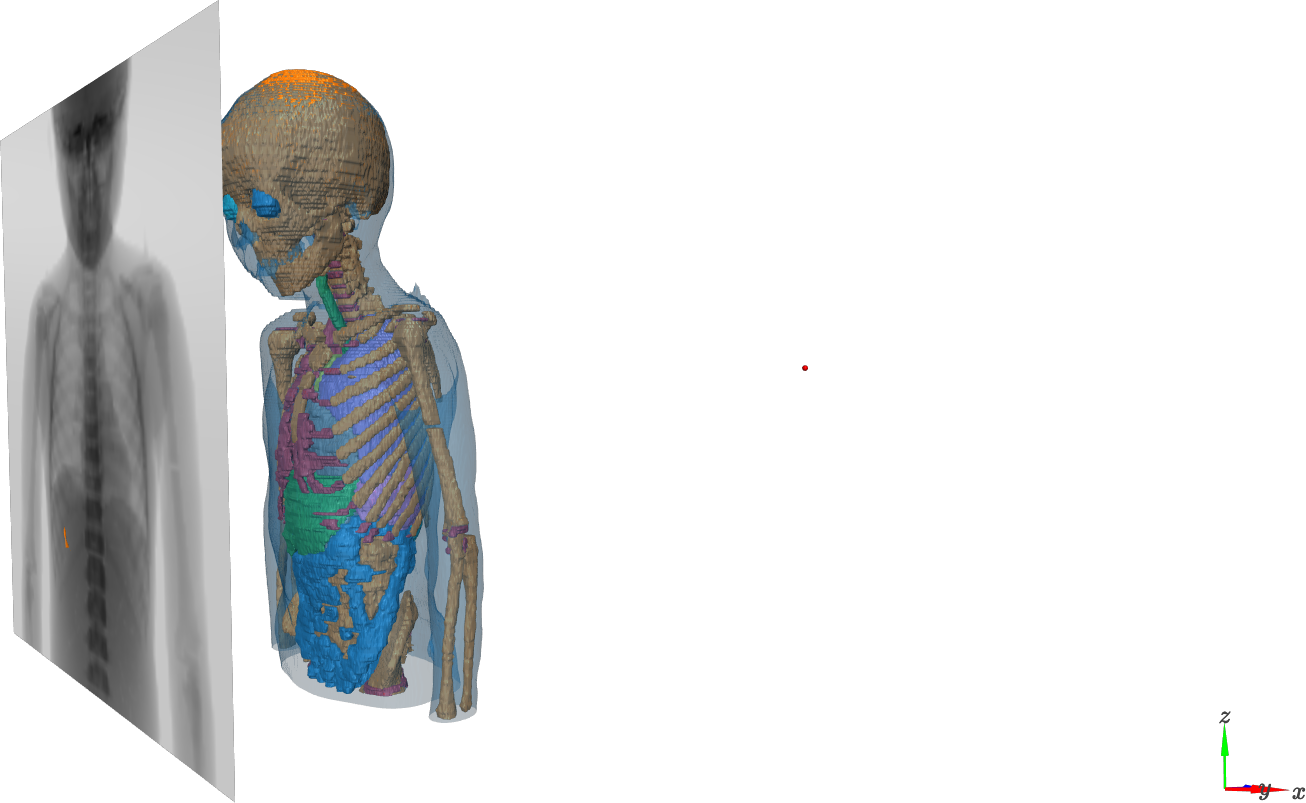

In [24]:
fname = root_path + "/visualisation.png"

if not os.path.exists(fname):

    if len(servers) > 0:
        from google.colab import output
        output.enable_custom_widget_manager()

    plot = visualise(use_log=True)
    plot.grid_visible = False

    if len(servers) > 0:
        from IPython.display import HTML
        plot.snapshot_type = 'inline'
        HTML(plot.get_snapshot())
    else:
        plot.display()
else:
    display(Image(fname, width=800))

In [25]:
if not os.path.exists(fname):
    if plot is not None:
    
        plot.fetch_screenshot()

        data = base64.b64decode(plot.screenshot)
        with open(fname,'wb') as fp:
            fp.write(data)

    if len(servers) > 0:
        from google.colab import output
        output.disable_custom_widget_manager()

## Add Poisson noise

1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction

In [26]:
def getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel):
    
    total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()
    number_of_incident_photons_per_pixel = np.sum(gvxr.getPhotonCountEnergyBins())
    energy2photons = number_of_incident_photons_per_pixel / total_energy_MeV

    temp = energy2photons / number_of_incident_photons_per_pixel * target_number_of_photons_per_pixel
    
    # Convert the image in keV into number of photons
    x_ray_image_photons = x_ray_image_energy * temp 
    
    # Add the Poisson noise
    noise_image = np.float32(np.random.poisson(x_ray_image_photons))

    # Convert in energy
    return noise_image / temp

In [27]:
fig_plot = None
def chooseNumberOfPhotonsPerPixel(xray_image: np.array, number_of_photons_per_pixel:int=15000, figsize=(10, 5)):

    """
    Use Matplotlib and a Jupyter widget to display the X-ray image with Poisson noise.
    The number of photons per pixel can be change interactively.

    @param xray_image: The image to display
    @number_of_photons_per_pixel: the number of photons per pixel (default: 15000)
    @gamma figsize: the size of the figure (default: (10, 5))
    """

    global target_number_of_photons_per_pixel, fig_plot
    target_number_of_photons_per_pixel = number_of_photons_per_pixel

    noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)

    fig_plot = plt.figure(figsize=figsize)
    ax_img = plt.subplot(111)
    img = plt.imshow(noisy_image, cmap="gray")
    # cbar = fig_plot.colorbar(img, orientation='vertical')
    title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
    ax_img.set_title(title_str)
    plt.tight_layout()
    plt.margins(0,0)

    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(number_of_photons_per_pixel):
        global target_number_of_photons_per_pixel
        target_number_of_photons_per_pixel = number_of_photons_per_pixel
        noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)
        img = ax_img.imshow(noisy_image, cmap="gray")
        title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
        ax_img.set_title(title_str)
        # fig_plot.colorbar(img, cax=cbar.ax, orientation='vertical')

        display(fig_plot)

    interact(update_plot,
             number_of_photons_per_pixel=widgets.IntSlider(value=number_of_photons_per_pixel, min=10, max=50000, step=10, description="Photons/pixels"))

In [28]:
chooseNumberOfPhotonsPerPixel(projection_in_MeV, number_of_photons_per_pixel=15000, figsize=(10, 5))

interactive(children=(IntSlider(value=15000, description='Photons/pixels', max=50000, min=10, step=10), Output…

In [29]:
fig_plot.savefig(root_path + "/noisy-projection.png", dpi=72)

In [30]:
print("Photons per pixels:", target_number_of_photons_per_pixel)

Photons per pixels: 15000


## Perfom the CT scan

In [31]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [32]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]
angles = json2gvxr.doCTScan()

In [33]:
print("First angle:", angles[0])
print("Last angle:", angles[-1])
print("Number of angles:", number_of_angles)

First angle: 0.0
Last angle: 359.4
Number of angles: 600


## Flat images

Create the flat field image

In [34]:
white_slider = widgets.IntSlider(value=25, min=1, max=500, step=1, description='Number of flat images:')
white_slider

IntSlider(value=25, description='Number of flat images:', max=500, min=1)

In [35]:
print("Number of flat images:", white_slider.value)

Number of flat images: 25


In [36]:
createDirectory(root_path + "/flat-field")
fname = root_path + "/flat-field/flat.tif"

total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()

temp = total_energy_MeV * np.ones([1, number_of_rows, number_of_cols], dtype=np.single)
flats = []

for i in range(white_slider.value):
    flats.append(getNoisyImage(temp, target_number_of_photons_per_pixel))

flat_field = np.average(flats, axis=0)

imwrite(fname, flat_field.astype(np.single), compression='zlib')

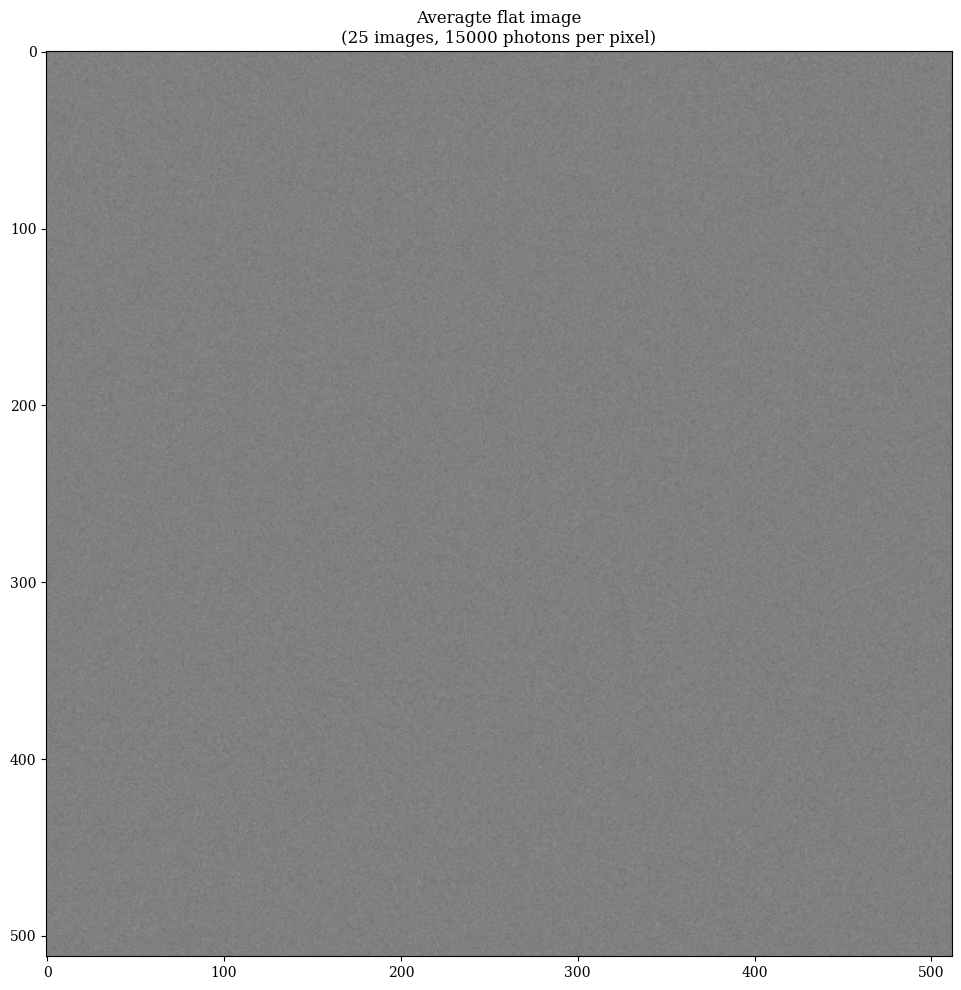

In [37]:
fig = plt.figure(figsize = (20, 10))
plt.title("Averagte flat image\n(" + str(white_slider.value) + " images, " + str(target_number_of_photons_per_pixel) + " photons per pixel)")
img = plt.imshow(flat_field[0], cmap='gray', vmin=total_energy_MeV-0.05*total_energy_MeV, vmax=total_energy_MeV+0.05*total_energy_MeV)
plt.tight_layout()
plt.savefig(root_path + "/average-flat-field.png", dpi=72)

## Add the noise to the projections

In [38]:
createDirectory(root_path + "/noiseless_projections")

raw_projections = []
for i in range(number_of_angles):

    print("Projection", i + 1, "/", number_of_angles, end='\r')

    input_fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    output_fname = root_path + "/noiseless_projections/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    
    # Load the raw projection in the RAM
    x_ray_image_energy = imread(input_fname).astype(np.single)

    # Save it
    imwrite(output_fname, x_ray_image_energy)

    # Add the Poisson noise
    noise_image = getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel)

    # Flat-field
    x_ray_image_energy = noise_image / flat_field[0]
    raw_projections.append(x_ray_image_energy.astype(np.single))

    # Overwrite the image
    imwrite(input_fname, raw_projections[-1])

## CT reconstruction

In [39]:
def reconstructFBPWithCIL(data, ig, use_plugins, verbose):
    if verbose > 0: print("Parallel beam detected")

    
    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_tigre(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FBP_recons_cil(data, ig, backend="tigre").run()
            
    elif has_astra:
        if verbose > 0: print("Backend: Astra-Toolbox")
        if verbose > 0: print("Use plugin directly: ", use_plugins)
        
        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_astra(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FBP_recons_cil(data, ig, backend="astra").run()

    else:
        raise ValueError("Tigre and Astra-toolbox are not installed")    
     
    return reconstruction

In [40]:
def reconstructFDKWithCIL(data, ig, use_plugins, verbose):
    if verbose > 0: print("Cone beam detected")

    # if has_tigre:
    #     if verbose > 0: print("Backend: Tigre")
    #     reconstruction:ImageData | None = FDK(data, ig).run()
    # else:
    #     if verbose > 0: print("Backend: Astra-Toolbox")
    #     fbk = FDK_Flexible(ig, data.geometry)
    #     fbk.set_input(data)
    #     reconstruction:ImageData | None = fbk.get_output()

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_tigre(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FDK_recons_cil(data, ig).run()

    elif has_astra:
        if verbose > 0: print("Backend: Astra-Toolbox")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_astra(ig,data.geometry)(data)
        else:
            # reconstruction:ImageData | None = FDK_recons_cil(data, ig).run() # Not implemented for Astra
            reconstruction:ImageData | None = None

    else:
        raise ValueError("Tigre and Astra-toolbox are not installed")    

    return reconstruction

In [41]:
def reconstruct(JSON_fname, use_plugin=False, verbose=0):
    import json
    
    # Opening JSON file
    f = open(JSON_fname)

    # returns JSON object as 
    # a dictionary
    json_data = json.load(f)    
    
    data = None
    reconstruction = None
    
    source_shape = json_data["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)

    # Use CIL
    if has_cil:
    
        if verbose > 0: print("Use CIL")

        reader = JSON2gVXRDataReader(file_name=JSON_fname)
        data = reader.read()

        print("data.geometry", data.geometry)
        
        if has_tigre:
            data.reorder(order='tigre')
        elif has_astra:
            data.reorder("astra")
        else:
            raise ValueError("Tigre and Astra-toolbox are not installed")    

        ig = data.geometry.get_ImageGeometry()

        data_corr = TransmissionAbsorptionConverter(white_level=data.max(), min_intensity=0.000001)(data)

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction:ImageData | None = reconstructFBPWithCIL(data_corr, ig, use_plugin, verbose)

            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, use_plugin, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, use_plugin, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

    else:
        raise ValueError("CIL is not installed")    

    return data, reconstruction

In [42]:
data, reconstruction = reconstruct(json_fname, True, verbose=1)

Source shape: PointSource
Use CIL
[512, 512]
[0.9765625, 0.9765625]
data.geometry 3D Cone-beam tomography
System configuration:
	Source position: [    0., -1000.,     0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [  0., 150.,   0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [512 512]
	Pixel size: [0.9765625 0.9765625]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 600
	Angles 0-20 in degrees:
[ 0.       ,  0.6010017,  1.2020034,  1.803005 ,  2.4040067,  3.0050085,
  3.60601  ,  4.2070117,  4.8080134,  5.409015 ,  6.010017 ,  6.611018 ,
  7.21202  ,  7.8130217,  8.414023 ,  9.015025 ,  9.616027 , 10.217029 ,
 10.81803  , 11.419032 ]
Distances in units: units distance
Cone beam detected
Backend: Tigre
Use plugin directly:  True


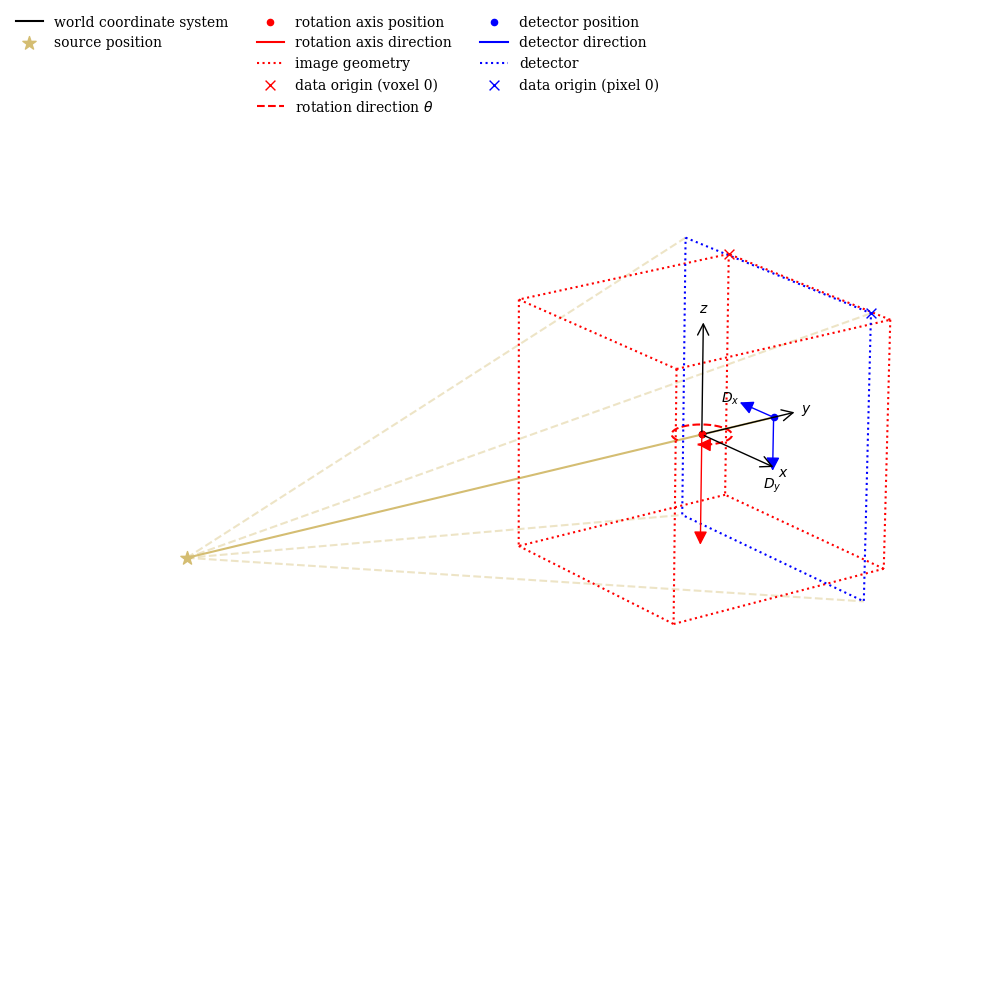

Saved image as /home/bih17925/CIL_user_notebooks/gVXR2CIL/CT-geometry.png


<Figure size 640x480 with 0 Axes>

In [43]:
if has_cil:
    fig = show_geometry(data.geometry)
    fig.save(root_path  + "/CT-geometry.png", dpi=72)

In [44]:
if has_cil and has_cil_islider:
    islicer(reconstruction, direction='vertical')

In [45]:
if has_cil and has_cil_islider:
    islicer(reconstruction, direction='horizontal_x')

In [46]:
fname = root_path  + "/CT_in_mu.mha"

In [47]:
reconstruction_as_array = reconstruction.as_array()

In [48]:
detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
spacing = detector_size / number_of_pixels

print("The CT volume will be saved in", fname)
sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
sitk.WriteImage(sitk_image, fname, useCompression=True)

The CT volume will be saved in /home/bih17925/CIL_user_notebooks/gVXR2CIL/CT_in_mu.mha


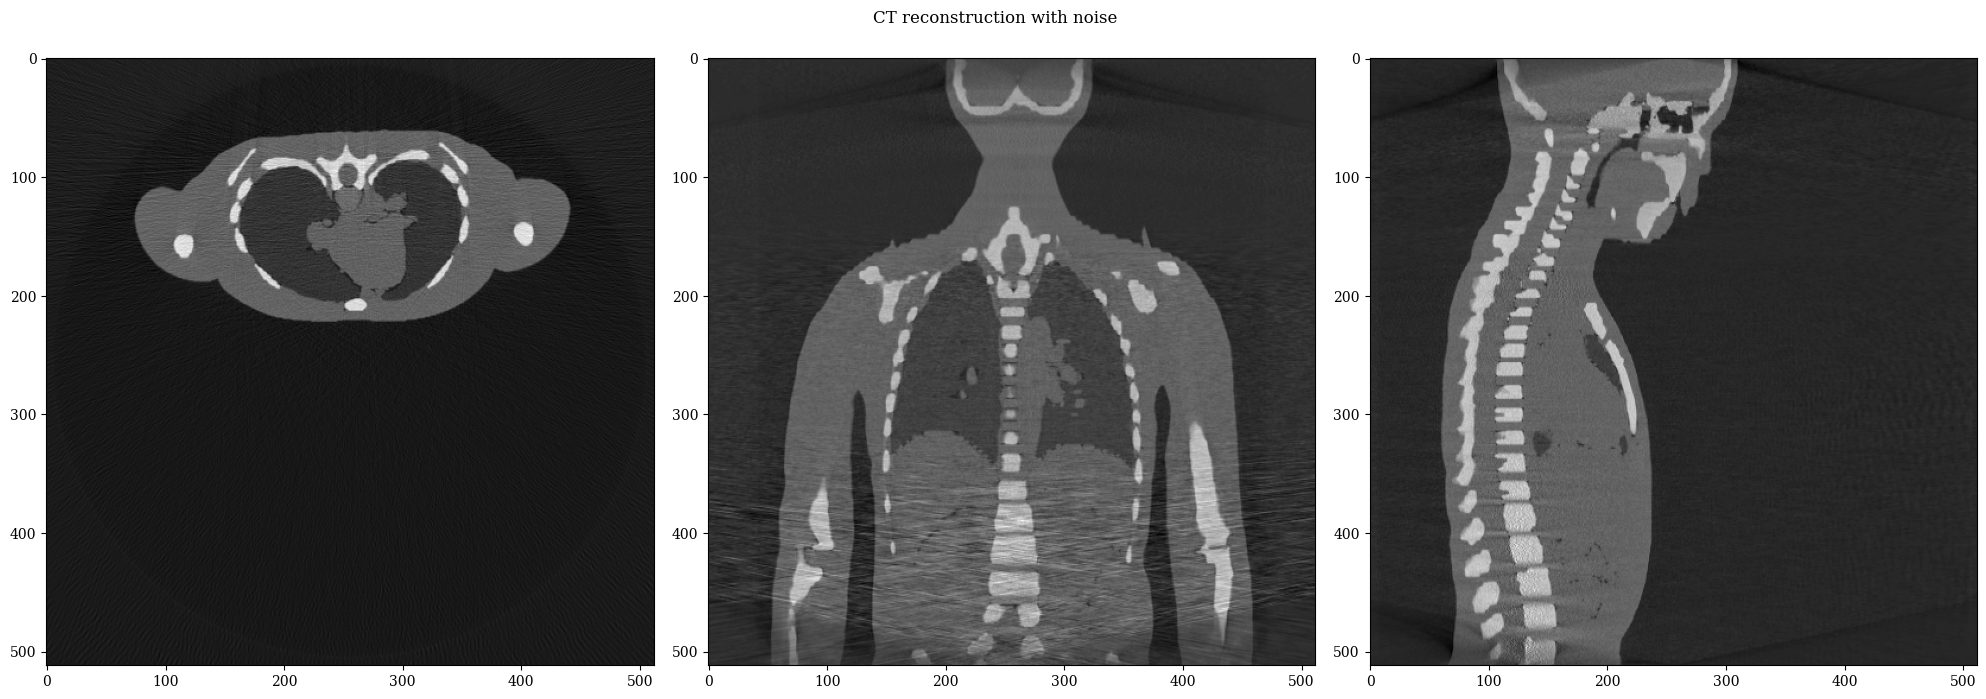

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
plt.suptitle("CT reconstruction with noise")
ax1.imshow(reconstruction_as_array[ int(reconstruction_as_array.shape[0] * 0.5), :, :], cmap='gray')
ax2.imshow(reconstruction_as_array[ :, int(reconstruction_as_array.shape[1] * 0.25), :], cmap='gray')
ax3.imshow(reconstruction_as_array[ :, :, int(reconstruction_as_array.shape[2] * 0.5)], cmap='gray')
plt.tight_layout()
plt.savefig(root_path  + "/plotCT.png", dpi=72)
plt.show()

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [50]:
gvxr.terminate()

Tue Aug 15 13:33:14 2023 ---- Destroy all the windows
Tue Aug 15 13:33:14 2023 ---- Destroy window 0(0x5557692c6870)
